# Cart Pendulum: Hamiltonian Dynamics

In [1]:
from ipywidgets import interact
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import sympy  as sp
import numpy as np
import control as ct
import control.matlab as ct_matlab

import slycot


# Deriving the equations

### Theory

##### Defining the variables
In Hamiltonian formulation for this system, the system states are \
$x_1$: Position of the cart along the horizontal (x-axis) \
$p_1$: The conjugate momentum of $x_1$ \
$x_2$: The angle measured along the negative y-axis \
$p_2$: The conjugate momentum of $x_2$ 

Note that the conjugate momentum need not be the momentum\angular momentum, such as $p = mv$ or $J = mr^2\omega$, we use in classical mechanics. It is calculated when we use the Legendre transformation to convert the Lagrangagian to Hamiltonian and is defined by the following equation

$
\begin{equation}
    p_i = \frac{\partial L}{\partial x_1}
\end{equation}
$

The Lagrangian $L$ of this system is defined as 
$
\begin{equation}
    L = ke - pe
\end{equation}
$
where $ke$ is the kinetic energy and $pe$ is the potential energy. Now we substitute $L$ in equation (1) and solve for the velocities as a function of the positions and conjugate momenta.

Next we calculate the Hamiltonian using the Legendre transformation
$
\begin{equation}
    H = x_1 p_1 + x_2 p_2 - L \\
\end{equation}
$

Finally we get the dynamics of this system using the Hamiltons equations, modified to include a control signal
$
\begin{equation}
    \begin{aligned}
        \dot{x_1} &=   -\frac{\partial H}{\partial p_1},  \space \space  \dot{p_1} =   \frac{\partial H}{\partial x_1}\\
        \dot{x_2} &=   -\frac{\partial H}{\partial p_2},  \space \space  \dot{p_2} =   \frac{\partial H}{\partial x_2}  
    \end{aligned}
\end{equation}
$

Here $u$ is the control signal

### Setting up positions and velocities

In [2]:
# The function for differentiation is cumbersome
# Defining lambdas for brevity
ddx = lambda f,x : sp.diff(f,x)
ddt = lambda f   : sp.diff(f,t)

# System parameters symbols
m_c, m_p, l, g = sp.symbols('m_c, m_p, l, g')

# Dictionary to store their numerical values
param_vals = {
    "m_c" : 1,
    "m_p" : 1,
    "g"  : -10,
    "l"  : 1
}

# Time and control input symbols
t, u =  sp.symbols('t, u')

# System state function symbols
# They are functions of time
# Position
x = sp.Function('x')
theta = sp.Function('theta')
# Conjugate momenta
p1 = sp.Function('p1')
p2 = sp.Function('p2')

# Velocities variables
v1 = ddt(x(t))
v2 = ddt(theta(t))

# Defining the position in the x-y plane
cart_x = x(t)
cart_y = 0
cart_pos = [cart_x, cart_y]

pend_x =  l*sp.sin(theta(t)) + x(t)
pend_y =  l*sp.cos(theta(t))
pendulum_pos = [pend_x, pend_y]

# Calculating the velocities
cart_vel = [ddt(x) for x in cart_pos]
pend_vel = [ddt(x) for x in pendulum_pos]

# Calculating the sum of velocity squared
cart_vel_squared = sum(v**2 for v in cart_vel)
pend_vel_squared = sum(v**2 for v in pend_vel)

### Calculating energy terms

In [3]:
# Kinetic energy
ke = m_c*cart_vel_squared/2 + m_p*pend_vel_squared/2

# Potential energy
pe = -m_p*g*pend_y

# Lagrangian: 
L  = ke - pe
# We are using the Langragian to express velocities as function 
# of conjugate momenta and to calculate the Hamiltonian using 
# a legendre transformation

# Equations connecting conjugate momenta and velocities
conjugate_momentum_eqs = [
    sp.simplify(p1(t) - ddx(L, v1)),
    sp.simplify(p2(t) - ddx(L, v2))
]

# Velcoties as a function of ps
vels_sol = sp.solve(conjugate_momentum_eqs, [v1, v2])
vels_sol = {v:vels_sol[v].simplify() for v in [v1, v2]}

# Legendre transformation: Lagrangian to Hamiltonian
H = p1(t)*v1 + p2(t)*v2 - L
H = H.subs(vels_sol).simplify()



#### Dynamics equations

In [4]:
# Hamiltons equations 
xd_exp =  ddx(H, p1(t)).simplify()
p1d_exp = -ddx(H, x(t)).simplify() - u
thetad_exp =  ddx(H, p2(t)).simplify()
p2d_exp = -ddx(H, theta(t)).simplify()

# Expressions to functions
to_eq    = lambda eq:sp.lambdify((x(t), p1(t), theta(t), p2(t), t, u, m_c, m_p, l, g), eq)
DE_eqs   = [xd_exp, p1d_exp, thetad_exp, p2d_exp]
DE_funcs = [to_eq(eq) for eq in DE_eqs]

### System dynamics function

In [5]:
def get_PendulumCartRates_Hamiltonian(X, t, uf, m_c, m_p, l, g):
    X_  = X
    u   = uf(X_)
    x, p1, theta, p2 = X_

    return [f(x, p1, theta, p2, t, u, m_c, m_p, l, g) for f in DE_funcs]

# Unforced dynamics

## Plotting sytle

In [6]:
# plt.style.use('bmh')
# plt.style.use('ggplot')
# plt.style.use('classic')
plt.style.use('fivethirtyeight')

plt.rcParams["figure.figsize"]   = (6,6)
plt.rcParams["figure.dpi"]       = 100
plt.rcParams["figure.facecolor"] = "ffffff"

plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["savefig.bbox"]       = "tight"
plt.rcParams["savefig.facecolor"]  = "ffffff"
plt.rcParams["savefig.dpi"]        = 100

# General font
plt.rcParams["font.size"]        = 14
plt.rcParams["text.color"]       = "black"

# Axis text properties
plt.rcParams["axes.labelsize"]   = 20
plt.rcParams["axes.labelweight"] = 1000
plt.rcParams["xtick.color"]      = "black"
plt.rcParams["ytick.color"]      = "black"

# The graph outline, background and grid properties
plt.rcParams["axes.facecolor"]   = "d6ebf2" # "e0e0e0"
plt.rcParams["axes.grid"]        = True          
plt.rcParams["grid.color"]       = "white"
plt.rcParams["axes.labelcolor"]  = "black"
plt.rcParams["axes.edgecolor"]   = "57adc7" # "888888" # "black"
plt.rcParams["axes.linewidth"]   = 1

# Padding between border and text
plt.rcParams["axes.titlesize"]   = 25
plt.rcParams["axes.titlepad"]    = 10
plt.rcParams["axes.titleweight"] = 500

# Legend position reference point
plt.rcParams["legend.loc"]       = "lower center"
plt.rcParams["legend.frameon"]   = True
# plt.rcParams["legend.shadow"]    = True
# plt.rcParams["legend.facecolor"] = "e0e0e0"

# The line plot thickness and colors
plt.rcParams["lines.linewidth"]  = 2.5
# plt.rcParams["axes.prop_cycle"]  = plt.cycler('color', [
#       "#eb7245",  "#0066a2",  "#f1be3e",  "#007188",  "#82d7c6" , "#82d7c6", "#c3312f"
#     ])



#### Animation plotting 

In [7]:
def animte_CartPend(result, ts, Xs, x_range = [-3,   3], y_range = [-1.1, 1.1], scale = 3):
    """
    Accepts cart state information and returns an animation
    """
    # Extracting the symbols
    x, theta = Xs

    # Setting axes range
    delta   = lambda ls: ls[1] - ls[0]
    aspect  = (delta(x_range)) / (delta(y_range))

    # setting matplotlib parameters
    plt.rcParams['figure.figsize'] = [aspect * scale, scale]
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['animation.html'] = 'jshtml'


    # Selecting the animation range
    res_plot = result[::50]
    ts_plot  = ts[::50]

    # Setting up the plot
    fig, ax     = plt.subplots()
    pend_plot,  = plt.plot([],[], 'o-', linewidth=2, ms=10, markerfacecolor='r')
    cart_plot,  = plt.plot([],[], 'ks', ms=10) 

    print(type(pend_plot))

    def init():
        ax.set_xlim(x_range[0], x_range[1])
        ax.set_ylim(y_range[0], y_range[1])
        ax.set_aspect('equal')

    def animate(iter):
        x_cart, _, th_pend, _ = res_plot[iter]
        sub_obs               = {x: x_cart, theta: th_pend, l: param_vals["l"]}
        x_pend, y_pend        = [sp.N(i.subs(sub_obs)) for i in pendulum_pos]

        pend_plot.set_data([x_cart, x_pend],[0, y_pend])
        cart_plot.set_data([x_cart]        ,[0])

    return animation.FuncAnimation(fig, animate, init_func=init, frames=len(res_plot), interval=50, blit=False, repeat=False)

#### Simlation

In [8]:
# Simulation parameters
dt = 0.001
t0 = 0
tn = 10
ts = np.arange(t0, tn, dt)
t_span = [0,dt]

# initial condition
x0  = [0,0,np.pi/2,0]

# We are not controlling. A trial control law
control_no = lambda x:0

# Integrations
out = odeint(get_PendulumCartRates_Hamiltonian, x0, ts, 
    args=(control_no, param_vals["m_c"], param_vals["m_p"], param_vals["l"], param_vals["g"])
)

#### Animation

<class 'matplotlib.lines.Line2D'>


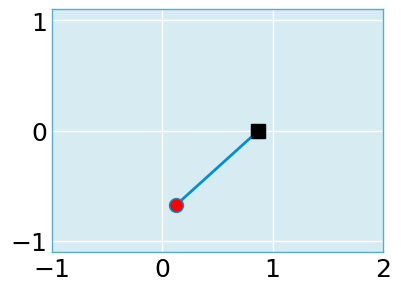

In [10]:
anim = animte_CartPend(out, ts, (x(t), theta(t)), x_range=[-1,2])
HTML(anim.to_jshtml())